<a href="https://colab.research.google.com/github/logicalbhanu/Interview_assignments/blob/main/nextLab_assignment_question2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing the fastai library

In [ ]:
!pip install wget
from fastai.text import *

## Downloading the Dataset.

We'll use The Corpus of Linguistic Acceptability (CoLA) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. It was first published in May of 2018, and is one of the tests included in the "GLUE Benchmark" on which models like BERT are competing.

In [ ]:
import wget
import os
%tensorflow_version 2.x

import tensorflow as tf
print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

2.8.0


In [ ]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

## Parsing the training and testing data.

In [ ]:
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
489,bc01,1,NaN,John tried.
6257,c_13,1,NaN,Robert knows that it is essential.
3786,ks08,1,NaN,They would inform Mary of any success they hav...
2686,l-93,0,*,Nora brought at the book to the meeting.
5658,c_13,1,NaN,The cat ate the spider.
2834,l-93,1,NaN,Alison poked the needle through the cloth.
2977,l-93,1,NaN,Her cousin clerked for Judge Davis.
8061,ad03,1,NaN,Julie felt he was there
4299,ks08,0,*,Stephen persuaded there to be a fountain in th...
5106,ks08,0,*,Order one first is what you should do.


The two properties we actually care about are the the `sentence` and its `label`, which is referred to as the "weather it is grammatically correct or not" (0=unacceptable, 1=acceptable).

In [ ]:
from sklearn.model_selection import train_test_split

train_sentences = df.sentence
train_labels = df.label
train_set = pd.concat([train_labels,train_sentences], axis=1)
new_train_set, new_val_set= train_test_split(train_set,test_size=0.10,shuffle=False)
new_train_set

,label,sentence
0,1,"Our friends won't buy this analysis, let alone..."
1,1,One more pseudo generalization and I'm giving up.
2,1,One more pseudo generalization or I'm giving up.
3,1,"The more we study verbs, the crazier they get."
4,1,Day by day the facts are getting murkier.
...,...,...
7690,1,I sent money to Mary.
7691,0,I sent Bill money to Mary to Sam.
7692,1,I worked on Sunday in the city on that project...
7693,1,I praised Mary.


In [ ]:
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
test_sentences = df.sentence
test_labels = df.label
new_test_set = pd.concat([test_labels,test_sentences], axis=1)
new_val_set

,label,sentence
7695,1,The moon glows in the darkness.
7696,1,The moon glows.
7697,1,I sang a song with Mary while you did so with ...
7698,1,What Mary did with Bill was sing a song.
7699,1,She tried to leave
...,...,...
8546,0,Poseidon appears to own a dragon
8547,0,Digitize is my happiest memory
8548,1,It is easy to slay the Gorgon.
8549,1,I had the strangest feeling that I knew you.


In [ ]:
new_train_set['label'].value_counts()

1    5407
0    2288
Name: label, dtype: int64

In [ ]:
new_val_set['label'].value_counts()

1    616
0    240
Name: label, dtype: int64

In [ ]:
#all imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
tf.test.gpu_device_name()

''

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [ ]:
import gc
gc.collect()

50

In [ ]:
train_set.head()

,label,sentence
0,1,"Our friends won't buy this analysis, let alone..."
1,1,One more pseudo generalization and I'm giving up.
2,1,One more pseudo generalization or I'm giving up.
3,1,"The more we study verbs, the crazier they get."
4,1,Day by day the facts are getting murkier.


In [ ]:
def get_wordlen(x):
    return len(x.split())
train_set['len'] = train_set.sentence.apply(get_wordlen)
for i in range(0,100,9):
  print(i,'th percentile =',train_set.len.quantile(i/100))

0 th percentile = 2.0
9 th percentile = 4.0
18 th percentile = 5.0
27 th percentile = 5.0
36 th percentile = 6.0
45 th percentile = 7.0
54 th percentile = 7.0
63 th percentile = 8.0
72 th percentile = 9.0
81 th percentile = 10.0
90 th percentile = 12.0
99 th percentile = 20.0


In [ ]:
train_set.len.quantile(1)

42.0

In [ ]:
max_len = 21
train_set = train_set[train_set.len<max_len]
# sampling 100000 samples randomly
#train_set = train_set.sample(n=100000, random_state=30)

In [ ]:
#split the data into train and test data(20%) with Stratify sampling, random state 33, 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_set['sentence'], train_set['label'], 
                                                    random_state=33, test_size=0.2, 
                                                    stratify=train_set['label'])

In [ ]:
y_train.shape

(6785,)

In [ ]:
len(y_train[y_train==0])

2002

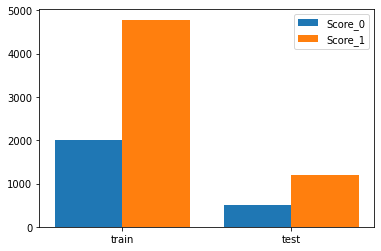

In [ ]:
#plot bar graphs of y_train and y_test
import matplotlib.pyplot as plt

# https://pythonguides.com/matplotlib-multiple-bar-chart/
# Define Data
score_0 = [len(y_train[y_train==0]), len(y_test[y_test==0])]
score_1 = [len(y_train[y_train==1]), len(y_test[y_test==1])]
x_axis = np.arange(len(score_0))

# Multi bar Chart
plt.bar(x_axis -0.2, score_0, width=0.4, label = 'Score_0')
plt.bar(x_axis +0.2, score_1, width=0.4, label = 'Score_1')
# shifting the x-axis coordinate with -0.2 and 0.2 would create
# a width of 0.4, thus width=0.4 to have perfect separation
# between the two bars

# Xticks
plt.xticks(x_axis, ['train','test'])

# Add legend
plt.legend()

# Display
plt.show()

# In the above code, we import libraries
# such as numpy and matplotlib.pyplot.
# After this, we define data for plotting.
# np.arange() method is used to create a range of values.
# Then plt.bar() function is used to plot multiple bar charts.
# Then we shift bars -0.2 and 0.2 units from the x-axis to avoid overlapping.
# Then we set the width of the bars to 0.4.

In [ ]:
X_train.values[716]

'Who did you introduce Athena to?'

In [ ]:
#saving to disk. if we need, we can load preprocessed data directly. 
train_set.to_csv('preprocessed.csv', index=False)

<pre><font size=6>Part-2: Creating BERT Model</font> 


In [ ]:
!pip install sentence_transformers

In [ ]:
X_train[:10]

6997    I consider that a rude remark and in very bad ...
8385                              I looked the number up.
8021                        Moya said she liked football.
1651      Here's a knife for you to say was on the table.
4678              This should be attended to immediately.
506                         I would like for John to win.
6331    Heidi said that pictures of herself were embar...
4228    The effectiveness of teaching and learning dep...
4492              Speaking not English is a disadvantage.
1233                            Max gave the car a shove.
Name: sentence, dtype: object

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')



In [ ]:
sentence_embeddings = []
for i in X_train:
  try:

    sentence_embeddings.append(model.encode([i]))
  except:
    print(i)


sentence_embeddings = np.array(sentence_embeddings).squeeze()
print(sentence_embeddings.shape)
X_train_embeddings = sentence_embeddings

(6785, 768)


In [ ]:

sentence_embeddings = []
for i in X_test:
  try:

    sentence_embeddings.append(model.encode([i]))
  except:
    print(i)


sentence_embeddings = np.array(sentence_embeddings).squeeze()
print(sentence_embeddings.shape)
X_test_embeddings = sentence_embeddings

(1697, 768)


<pre><font size=6>Part-3: Training a NN with 768 features</font>


In [ ]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM, BatchNormalization
from tensorflow.keras.models import Model

In [ ]:
from sklearn.metrics import roc_auc_score 
 
def auc1(y_true, y_pred): 
    try:
        return roc_auc_score(y_true, y_pred)
    except:
        return 0.5 # this has been done to prevent only one class presence in y_true in any batch
def auroc(y_true, y_pred): 
    return  tf.py_function(auc1, (y_true, y_pred), tf.double) #tf.function(auc1)(y_true, y_pred)

In [ ]:
tf.keras.backend.clear_session() 

In [ ]:
input_layer=Input(shape=(X_train_embeddings.shape[1],))
Dense_1 = Dense(256)(input_layer)
dropout_1 = Dropout(0.2)(Dense_1)
Dense_2 = Dense(128)(dropout_1)
dropout_2 = Dropout(0.2)(Dense_2)
Dense_3 = Dense(64)(dropout_2)
Batch_norm = BatchNormalization()(Dense_3)
output_layer = Dense(1, activation='sigmoid')(Batch_norm)
model_1 = Model(inputs = input_layer, outputs=output_layer)


In [ ]:
import datetime,os
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True) 

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint 
filepath="model_save/weights_m2-{epoch:02d}-{val_accuracy:.4f}.hdf5" 
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=False, mode='auto') 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping 
# this is to stop the training if val_accuracy doesn't improves more than  
# 0.0001 in two epochs 
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=4, mode='max') 

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization (BatchN  (None, 64)               256   

In [ ]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss='binary_crossentropy', metrics=['accuracy',auroc])

In [ ]:
type(X_train_embeddings)

numpy.ndarray

In [ ]:
model_1.fit(x=X_train_embeddings,  
          y=y_train,  
          epochs=55,  
          batch_size=64,
          validation_data=(X_test_embeddings, y_test),  
          callbacks=[ checkpoint, tensorboard_callback]) 

Epoch 1/55
107/107 [==============================] - 2s 17ms/step - loss: 0.4634 - accuracy: 0.7826 - auroc: 0.8170 - val_loss: 0.5703 - val_accuracy: 0.7236 - val_auroc: 0.7188
Epoch 2/55
107/107 [==============================] - 1s 9ms/step - loss: 0.4617 - accuracy: 0.7794 - auroc: 0.8229 - val_loss: 0.5628 - val_accuracy: 0.7254 - val_auroc: 0.7189
Epoch 3/55
107/107 [==============================] - 1s 9ms/step - loss: 0.4608 - accuracy: 0.7813 - auroc: 0.8201 - val_loss: 0.5703 - val_accuracy: 0.7118 - val_auroc: 0.7117
Epoch 4/55
107/107 [==============================] - 1s 8ms/step - loss: 0.4633 - accuracy: 0.7828 - auroc: 0.8169 - val_loss: 0.5709 - val_accuracy: 0.7289 - val_auroc: 0.7126
Epoch 5/55
107/107 [==============================] - 1s 8ms/step - loss: 0.4630 - accuracy: 0.7788 - auroc: 0.8206 - val_loss: 0.5759 - val_accuracy: 0.7219 - val_auroc: 0.7158
Epoch 6/55
107/107 [==============================] - 1s 8ms/step - loss: 0.4607 - accuracy: 0.7814 - auroc: 

In [ ]:
!pip install gdown

### Downloading and preprocessing the prediction dataset

In [ ]:
!gdown 1LTI5KNqPrtxrYRgJk2AxI30KgYyNcRpD

Downloading...
From: https://drive.google.com/uc?id=1LTI5KNqPrtxrYRgJk2AxI30KgYyNcRpD
To: /content/review_data.csv
100% 2.71M/2.71M [00:00<00:00, 72.2MB/s]


In [ ]:
testing = pd.read_csv('/content/review_data.csv')

In [ ]:
testing.head()

,text,star,app_id,reviewDate
0,Anathi Khanyile,5,com.fingersoft.hillclimb,18/03/21
1,Tony bahut funny hai Hill climbing racing my f...,5,com.fingersoft.hillclimb,18/03/21
2,Teturwu,1,com.fingersoft.hillclimb,18/03/21
3,Hoooooooooooyaaaaaaaaa what a game hoooooooooo...,5,com.fingersoft.hillclimb,18/03/21
4,This game is nice,5,com.fingersoft.hillclimb,18/03/21


In [ ]:
testing['text'].values

array(['Anathi Khanyile', 'Tony bahut funny hai Hill climbing racing my favourite game', 'Teturwu',
       'Hoooooooooooyaaaaaaaaa what a game hooooooooooooyaaaaaaaa', ..., 'Nice', 'Disturbing too much as YouTube ad',
       'Koub valo vai', 'I want to grow my account'], dtype=object)

In [ ]:
testing = testing[testing['text'].notna()]
testing['text'].values.shape

In [ ]:
sentence_embeddings = []
for i in testing['text'].values:
  try:

    sentence_embeddings.append(model.encode([i]))
  except:
    print(i)


sentence_embeddings = np.array(sentence_embeddings).squeeze()
print(sentence_embeddings.shape)
X_testing = sentence_embeddings

nan
(29999, 768)


In [ ]:
result = model_1.predict(X_testing)

In [ ]:
result_label = [1 if prediction>=0.5 else 0 for prediction in result]
result_accr_percent = [prediction*100 for prediction in result]

In [ ]:
testing['predicted_labels']=result_label
testing['grammatical_accuracy']=result_accr_percent

In [ ]:
testing.head()

,text,star,app_id,reviewDate,predicted_labels,grammatical_accuracy
0,Anathi Khanyile,5,com.fingersoft.hillclimb,18/03/21,0,[40.050106]
1,Tony bahut funny hai Hill climbing racing my f...,5,com.fingersoft.hillclimb,18/03/21,0,[41.626587]
2,Teturwu,1,com.fingersoft.hillclimb,18/03/21,0,[5.4914923]
3,Hoooooooooooyaaaaaaaaa what a game hoooooooooo...,5,com.fingersoft.hillclimb,18/03/21,1,[99.335785]
4,This game is nice,5,com.fingersoft.hillclimb,18/03/21,1,[80.43008]
